<a href="https://colab.research.google.com/github/CesarAugusto88/PDI/blob/main/Neurocomputa%C3%A7%C3%A3o_Segmention_and_Regression_Keras_(19_07_2022).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neurocomputação
## Prof. Marcos G. Quiles
### Cesar Augusto de Moraes Costa





In [307]:
# importing image pansharpening
!gdown --id 1ER7V68nXfx28vzDNpCrIG1Ev8iIbIwHt
# importing data points
!gdown --id 139XYm5irDHy3QBwBxJmat9PNCe3gWozQ
!gdown --id 1zglwC24nnUPrufNOFLq2xhI6vv0yTYfm
!gdown --id 1iy3s4CLZuou979MUbkU2QO76ViqZdkPn
!gdown --id 1HkKxnYdjID28xJD8vD0SHqOVwdiqs4GB
!gdown --id 1bYrIXqPRqxXo2Z7cA4P7laHolHku9LQW

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ER7V68nXfx28vzDNpCrIG1Ev8iIbIwHt
To: /content/pansharpening_corte1_sjcampos.tif
100% 3.99M/3.99M [00:00<00:00, 215MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=139XYm5irDHy3QBwBxJmat9PNCe3gWozQ
To: /content/truth_data.shx
100% 532/532 [00:00<00:00, 854kB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downl

In [308]:
# install libraries
# !nvidia-smi # GPU
!pip install geopandas
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [309]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdal
import ogr
from numpy import MAXDIMS

from skimage import exposure
from skimage.segmentation import quickshift, slic
from skimage import segmentation
import time
import scipy
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, accuracy_score

import os
import torch
import torch.nn.functional as F
import tqdm
# from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch_geometric.nn import MessagePassing, SAGEConv
# from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim


from keras.layers import Dense, Activation, Flatten

import math

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2


# Rasterize Training Data

In [310]:
# open NAIP image as a gdal raster dataset
naip_fn = '/content/pansharpening_corte1_sjcampos.tif' 
driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)
type(naip_ds)

osgeo.gdal.Dataset

In [311]:
nbands = naip_ds.RasterCount
band_data = []
print('bands', naip_ds.RasterCount, 'rows', naip_ds.RasterYSize, 'columns', naip_ds.RasterXSize)
for i in range(1, nbands+1):
  band = naip_ds.GetRasterBand(i).ReadAsArray()
  band_data.append(band)
band_data = np.dstack(band_data)  # b for b in band_data
print(band_data.shape)  # 4 bandas e após segmentação em 1

bands 4 rows 450 columns 554
(450, 554, 4)


In [312]:
img = exposure.rescale_intensity(band_data)
seg_start = time.time()
#segments = quickshift(img.astype("double"), convert2lab=False) # OK / agora com erro
#segments = quickshift(img.astype("double"), ratio=0.1, convert2lab=False)  # error assert com ratio>0.4
# segments = slic(img, n_segments=50000, compactness=0.3)  # very good
segments = slic(img, n_segments=50000, compactness=0.3) 
# segments = slic(img, n_segments=500000, compactness=0.01)
#segments = quickshift(img.astype("double"), ratio=0.99, max_dist=5, convert2lab=False)
# segments = slic(img, n_segments=500000, compactness=0.1)
print('segments complete', time.time() - seg_start)
def segment_features(segment_pixels):
  features = []
  npixels, nbands = segment_pixels.shape
  for b in range(nbands):
    stats = scipy.stats.describe(segment_pixels[:,b])
    band_stats = list(stats.minmax) + list(stats)[2:]
    if npixels == 1:
      # in this case the variance = nan, change it 0.0
      band_stats[3] = 0.0
    features += band_stats
  return features

obj_start = time.time()
segment_ids = np.unique(segments)
objects = []
objects_ids = []
for id in segment_ids:
  segment_pixels = img[segments == id]
  print('pixels for id', id, segment_pixels.shape)
  object_features = segment_features(segment_pixels)
  objects.append(object_features)
  objects_ids.append(id)

print('created', len(objects), 'objects with', len(objects[0]), 'variables in',
      time.time()-obj_start, 'seconds')

# save segments to raster
segments_fn = '/content/segments.tif'
segments_ds = driverTiff.Create(segments_fn, naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_Float32)
segments_ds.SetGeoTransform(naip_ds.GetGeoTransform())
segments_ds.SetProjection(naip_ds.GetProjectionRef())
segments_ds.GetRasterBand(1).WriteArray(segments)
segments_ds = None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  


Streaming output truncated to the last 5000 lines.
pixels for id 57157 (4, 4)
pixels for id 57158 (4, 4)
pixels for id 57159 (4, 4)
pixels for id 57160 (4, 4)
pixels for id 57161 (4, 4)
pixels for id 57162 (4, 4)
pixels for id 57163 (4, 4)
pixels for id 57164 (4, 4)
pixels for id 57165 (4, 4)
pixels for id 57166 (4, 4)
pixels for id 57167 (4, 4)
pixels for id 57168 (4, 4)
pixels for id 57169 (4, 4)
pixels for id 57170 (4, 4)
pixels for id 57171 (4, 4)
pixels for id 57172 (4, 4)
pixels for id 57173 (4, 4)
pixels for id 57174 (4, 4)
pixels for id 57175 (4, 4)
pixels for id 57176 (4, 4)
pixels for id 57177 (4, 4)
pixels for id 57178 (4, 4)
pixels for id 57179 (4, 4)
pixels for id 57180 (4, 4)
pixels for id 57181 (4, 4)
pixels for id 57182 (4, 4)
pixels for id 57183 (4, 4)
pixels for id 57184 (4, 4)
pixels for id 57185 (4, 4)
pixels for id 57186 (4, 4)
pixels for id 57187 (4, 4)
pixels for id 57188 (4, 4)
pixels for id 57189 (4, 4)
pixels for id 57190 (4, 4)
pixels for id 57191 (4, 4)
pixe

In [313]:
# read shapefile to geopandas geodataframe
gdf = gpd.read_file('/content/truth_data.shp')  # PONTOS AMOSTRAIS
gdf

,ktype,geometry
0,agua,POINT (396890.488 7439395.464)
1,agua,POINT (397012.515 7439403.851)
2,agua,POINT (396889.797 7439495.421)
3,agua,POINT (397303.494 7438938.111)
4,agua,POINT (396801.606 7438881.836)
5,agua,POINT (396982.671 7439684.670)
6,agua,POINT (397087.168 7438947.936)
7,arvore,POINT (397184.649 7439354.115)
8,arvore,POINT (397065.551 7439426.850)
9,arvore,POINT (396835.275 7439687.424)


In [314]:
# get names of land cover classes/labels
class_names = gdf['ktype'].unique()
print('class names', class_names)

class names ['agua' 'arvore' 'construcao' 'grama']


In [315]:
# create a unique id (integer) for each land cover class/label
class_ids = np.arange(class_names.size) + 1
print('class ids', class_ids)

class ids [1 2 3 4]


In [316]:
# create a data frame of the labels and ids and save to csv
df = pd.DataFrame({'ktype': class_names, 'id': class_ids})
df.to_csv('/content/class_lookup.csv')
print('gdf without ids')
print(gdf.head())
gdf['id'] = gdf['ktype'].map(dict(zip(class_names, class_ids)))
print('gdf whith ids')
print(gdf.head(n=30))

gdf without ids
  ktype                        geometry
0  agua  POINT (396890.488 7439395.464)
1  agua  POINT (397012.515 7439403.851)
2  agua  POINT (396889.797 7439495.421)
3  agua  POINT (397303.494 7438938.111)
4  agua  POINT (396801.606 7438881.836)
gdf whith ids
         ktype                        geometry  id
0         agua  POINT (396890.488 7439395.464)   1
1         agua  POINT (397012.515 7439403.851)   1
2         agua  POINT (396889.797 7439495.421)   1
3         agua  POINT (397303.494 7438938.111)   1
4         agua  POINT (396801.606 7438881.836)   1
5         agua  POINT (396982.671 7439684.670)   1
6         agua  POINT (397087.168 7438947.936)   1
7       arvore  POINT (397184.649 7439354.115)   2
8       arvore  POINT (397065.551 7439426.850)   2
9       arvore  POINT (396835.275 7439687.424)   2
10      arvore  POINT (397487.168 7438984.640)   2
11      arvore  POINT (397530.933 7439722.395)   2
12      arvore  POINT (397662.255 7439393.234)   2
13      arvore  

In [317]:
# split the truth data into training and test data sets
gdf_train = gdf.sample(frac=0.5)
gdf_test = gdf.drop(gdf_train.index)
print('gdf shape', gdf.shape, 'training shape', gdf_train.shape, 'test', gdf_test.shape)
# Com validação 
# gdf_train, gdf_val, gdf_test = np.split(gdf.sample(frac=1), [int(.6*len(gdf)), int(.8*len(gdf))])
# print('gdf shape', gdf.shape, 'training shape', gdf_train.shape, 'validation', gdf_val.shape, 'test', gdf_test.shape)

gdf shape (54, 3) training shape (27, 3) test (27, 3)


In [318]:
# save each to a new shapefile
gdf_train.to_file('/content/train.shp')
# gdf_val.to_file('/content/val.shp')
gdf_test.to_file('/content/test.shp')

### Train and regression image


In [319]:
train_fn = '/content/train.shp'
train_ds = ogr.Open(train_fn)
lyr = train_ds.GetLayer()
# create a new raster layer in memory
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
# rasterize the training points
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
# retrieve the rasterized data and print basic stats
data = target_ds.GetRasterBand(1).ReadAsArray()
print('min', data.min(), 'max', data.max(), 'mean', data.mean())

ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

classes = np.unique(ground_truth)[1:]
print('class values', classes)

segments_per_class = {}

for klass in classes:
    segments_of_class = segments[ground_truth == klass]  # With the segmentation
    segments_per_class[klass] = set(segments_of_class)
    print("Training segments for class", klass, ":", len(segments_of_class))

intersection = set()
accum = set()

for class_segments in segments_per_class.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0, "Segment(s) represent multiple classes"

##########
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    class_label = threshold + klass
    for segment_id in segments_per_class[klass]:
        train_img[train_img == segment_id] = class_label

train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold
training_objects = []
training_labels  = []
for klass in classes:
    class_train_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] * len(class_train_object)
    training_objects += class_train_object
    print('Training objects for class', klass, ':', len(class_train_object))

# a=0
# for i in training_objects:  # Cada 1 item com 24 itens
#   print(a+1, '-', i)
#   a+=1
# a=0
# for i in training_labels:  # Cada 1 item com 1 itens
#   print(a+1, '-', i)
#   a+=1

min 0 max 4 mean 0.0002888086642599278
class values [1 2 3 4]
Training segments for class 1 : 4
Training segments for class 2 : 8
Training segments for class 3 : 8
Training segments for class 4 : 7
Training objects for class 1 : 4
Training objects for class 2 : 8
Training objects for class 3 : 8
Training objects for class 4 : 7


In [320]:
# https://stackoverflow.com/questions/63279168/valueerror-input-0-of-layer-sequential-is-incompatible-with-the-layer-expect
# https://stackoverflow.com/questions/48851558/tensorflow-estimator-valueerror-logits-and-labels-must-have-the-same-shape

X_train, X_test, y_train, y_test = train_test_split(training_objects, training_labels,
                                                    test_size=0.25,
                                                    random_state=123)

# X_train = np.asarray(X_train)
# X_test = np.asarray(X_test)
# y_train = np.asarray(y_train)
# y_test = np.asarray(y_test)

X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)

print('Tamanho de X_train: ', X_train.shape)
print('Tamanho de X_test: ', X_test.shape)
print('Tamanho de y_train: ', y_train.shape)
print('Tamanho de y_test: ', y_test.shape)

# X_train = np.asarray(X_train).astype('float32').reshape((-1,1))
# X_test = np.asarray(X_test).astype('float32').reshape((-1,1))
# y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
# y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

Tamanho de X_train:  (20, 24, 1)
Tamanho de X_test:  (7, 24, 1)
Tamanho de y_train:  (20, 1)
Tamanho de y_test:  (7, 1)


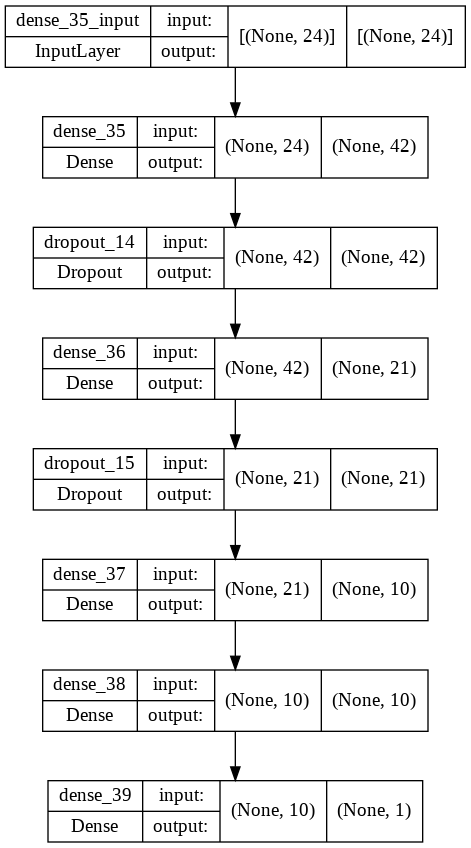

In [321]:
fl2 = 0.0
drop = 0.2
# model = keras.models.Sequential()  # Cria uma rede neural sequencial - feed foward
# model.add(keras.layers.Dense(20, activation='relu', input_shape=(X_train.shape[1],))) # primeira hidden layer
# model.add(keras.layers.Dense(20, activation='LeakyReLU')) # segunda hidden layer
# # model.add(keras.layers.Dense(1, activation= 'linear')) # output layer com ativação linear

# # model.add(tf.keras.layers.Dense(256, input_shape=(X_train.shape[1],), activation='sigmoid'))
# model.add(tf.keras.layers.Dense(1, input_shape=(X_train.shape[1],), activation='linear'))

# model.add(keras.layers.Dense(units=42, kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
# model.add(Dropout(drop))
# model.add(keras.layers.Dense(units=21, kernel_regularizer=l2(fl2), activation="tanh"))
# model.add(Dropout(drop))
# model.add(keras.layers.Dense(units=10, activation="tanh"))
# model.add(keras.layers.Dense(units=10, activation="tanh"))
# model.add(keras.layers.Dense(units=1, activation="linear"))

model = keras.Sequential()
model.add(keras.layers.Dense(units=42, kernel_regularizer=l2(fl2), input_shape=(X_train.shape[1],), activation="tanh"))
model.add(Dropout(drop))
model.add(keras.layers.Dense(units=21, kernel_regularizer=l2(fl2), activation="tanh"))
model.add(Dropout(drop))
model.add(keras.layers.Dense(units=10, activation="tanh"))
model.add(keras.layers.Dense(units=10, activation="tanh"))
model.add(keras.layers.Dense(units=1, activation="linear"))

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.6)  # Alterar momentum
adam = tf.keras.optimizers.Adam()

model.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

tf.keras.utils.plot_model(model, show_shapes=True)

In [322]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history = model.fit(X_train, y_train, epochs=3000, batch_size=10, 
                    validation_split=0.2, 
                    verbose=False,
                    callbacks=[early])

# print("Network parameters: {}".format(model.get_weights()))

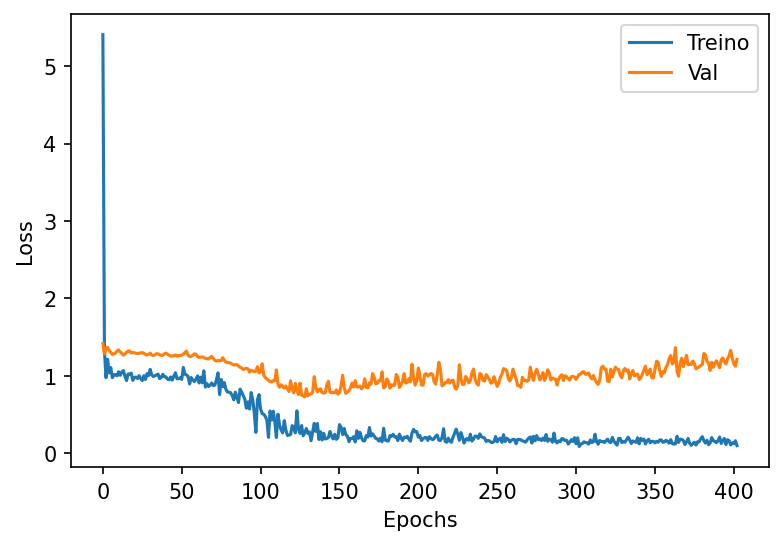

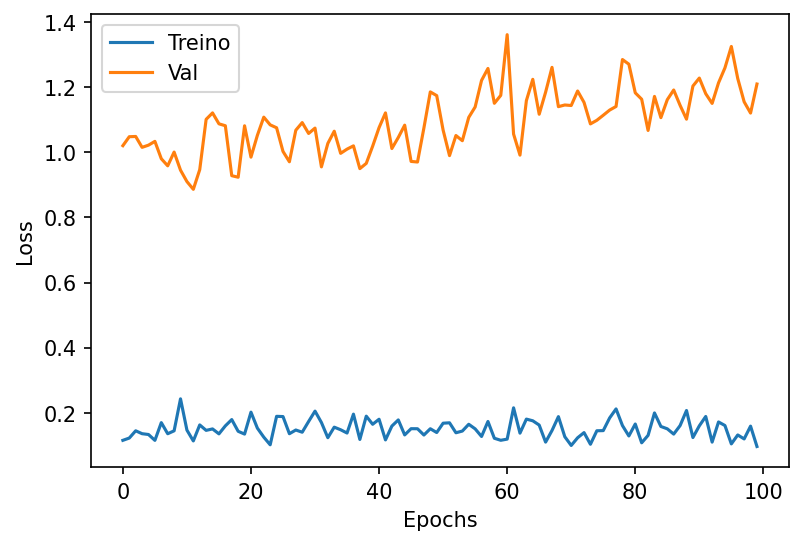

In [323]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Treino")
plt.plot(history.history['val_loss'], label="Val")
plt.legend()
plt.show()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history['loss'][-100:], label="Treino")
plt.plot(history.history['val_loss'][-100:], label="Val")
plt.legend()
plt.show()

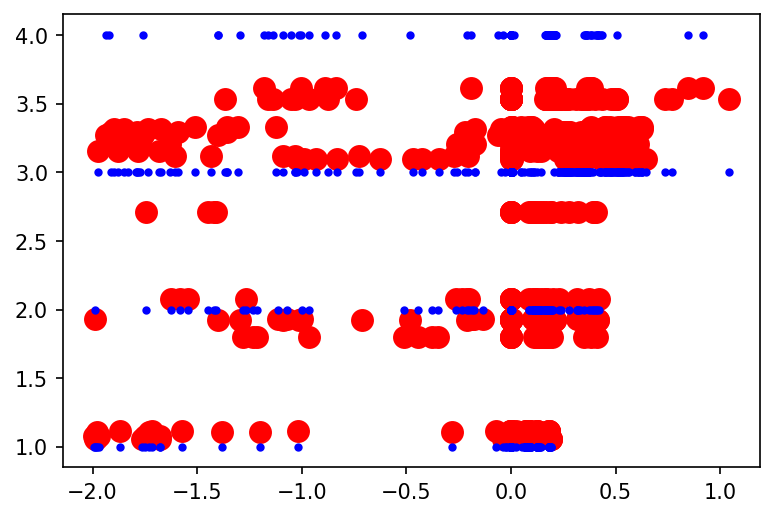

In [324]:
X_train, X_test, y_train, y_test = train_test_split(training_objects, training_labels,
                                                    test_size=0.25,
                                                    random_state=123)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

y_rest = model.predict(X_train)
plt.plot(X_train, y_rest, '.', markersize=20 ,color='red')
plt.plot(X_train, y_train, '.', color='blue')
plt.show()

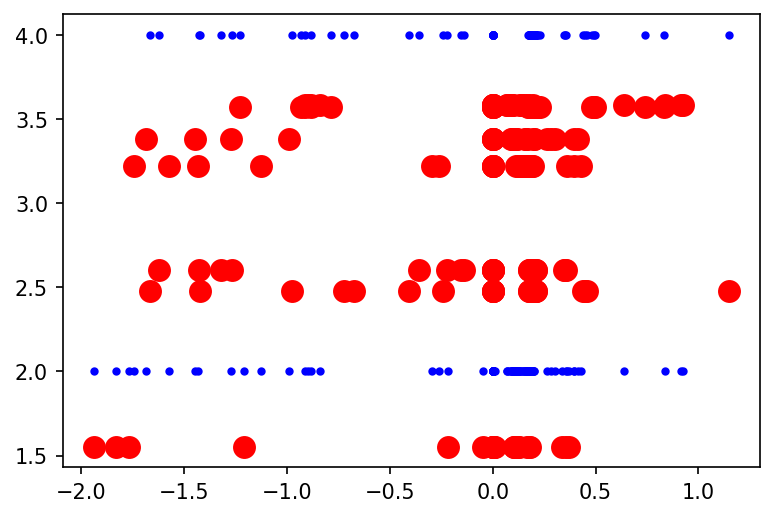

1/1 [==============================] - 0s 259ms/step - loss: 1.5107 - mean_absolute_error: 1.1412


In [325]:
y_res = model.predict(X_test)
plt.plot(X_test, y_res, '.', markersize=20, color='red')
plt.plot(X_test, y_test, '.', color='blue')
plt.show()

test_loss = model.evaluate(X_test, y_test)

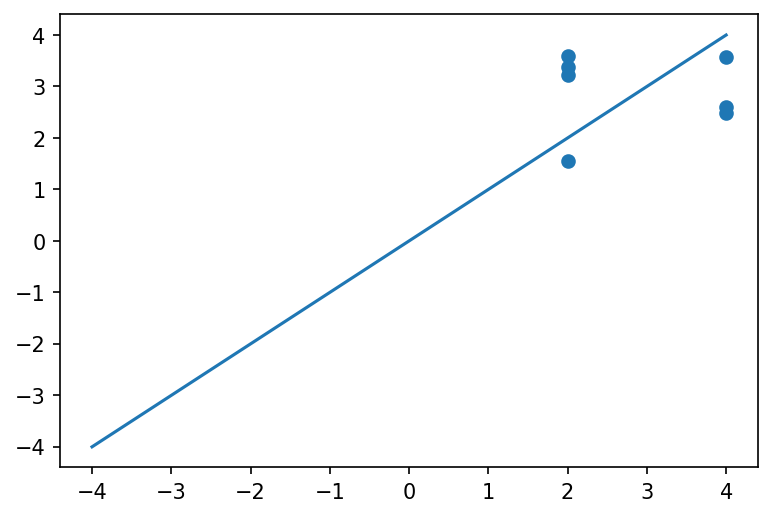

In [326]:
plt.scatter(y_test, y_res)
plt.plot([-4,4], [-4,4])
plt.show()

# Avaliação (teste)

In [327]:
###################################################

In [328]:
model.compile(loss=keras.losses.binary_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

In [329]:
batch_size = 32  # X_train 535 / 32 = 16.71 (então são 17 batches de 32)
epochs = 100

history  = model.fit(X_train, y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(X_test, y_test))

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: -24.3988 - accuracy: 0.2000 - val_loss: -28.3200 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 102ms/step - loss: -24.3893 - accuracy: 0.2000 - val_loss: -28.3200 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 76ms/step - loss: -24.3897 - accuracy: 0.2000 - val_loss: -28.3200 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 91ms/step - loss: -24.3959 - accuracy: 0.2000 - val_loss: -28.3200 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 88ms/step - loss: -24.3988 - accuracy: 0.2000 - val_loss: -28.3200 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 62ms/step - loss: -24.3988 - accuracy: 0.2000 - val_loss: -28.3200 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 55ms/step - loss: -24.3874 - accuracy: 0.2000 - val_loss: -

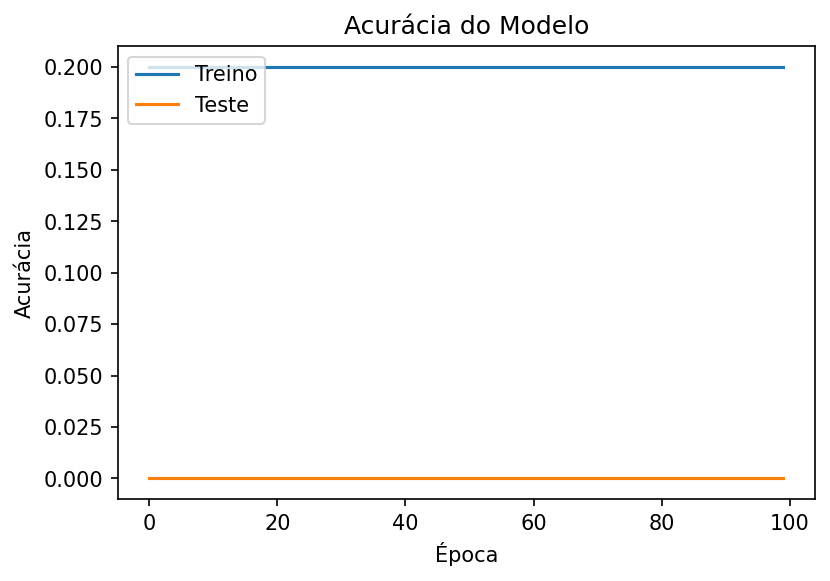

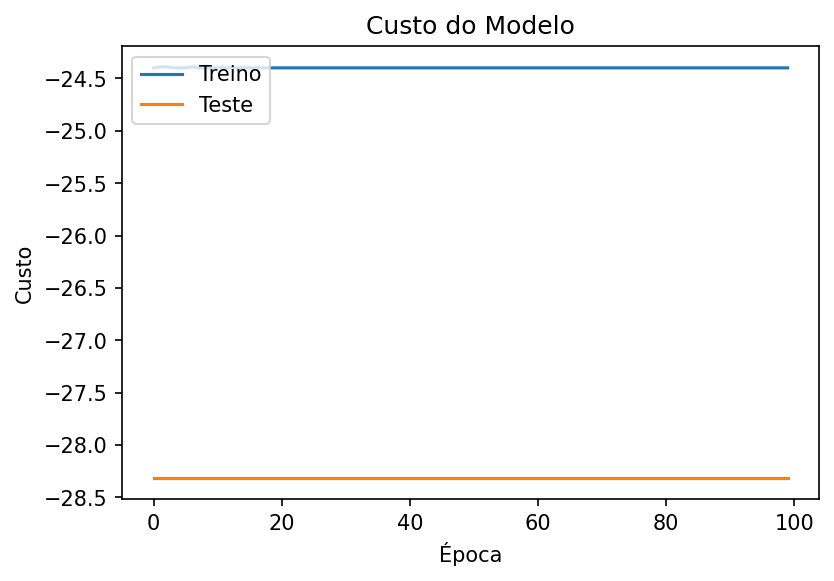

In [330]:
plt.rcParams['figure.dpi'] = 150

# Plot acurácia de treino e validação
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

# Plot custo de treino e validação
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Custo do Modelo')
plt.ylabel('Custo')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

In [331]:
model.evaluate(X_test, y_test)

# X_test 179 / 32 = 5.59 (então são 6 batches de 32)

1/1 [==============================] - 0s 37ms/step - loss: -28.3200 - accuracy: 0.0000e+00


[-28.32001304626465, 0.0]

In [332]:
(model.predict(X_test) > 0.5).astype('int32')

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

In [333]:
################################################################

In [334]:
# Regressão usando redes MLP:
# Ajustando a rede aos dados
# model = MLPRegressor(random_state = 2, max_iter = 2000, 
#                      hidden_layer_sizes = (4,300,300,2), 
#                      learning_rate = 'adaptive', activation = 'relu')
# mlp_reg = model.fit(training_objects, training_labels)

# predições para o conjunto de teste

# X_train = np.asarray(X_train)
# X_test = np.asarray(X_test)
# y_train = np.asarray(y_train)
# y_test = np.asarray(y_test)

objects = tf.expand_dims(objects, axis=-1)

predictions = model.predict(objects)
# predictions = model.predict(X_test)

###################               
print('Predicting Regression (MLPR)')
clf_mlpr = np.copy(segments)
for segment_id, klass in zip(segment_ids, predictions):
    clf_mlpr[clf_mlpr == segment_id] = klass
print('Prediction applied to numpy array (mlpr)')

mask_mlp = np.sum(img, axis=2)
mask_mlp[mask_mlp > 0.0] = 1.0
mask_mlp[mask_mlp == 0.0] = -1.0
clf_mlpr = np.multiply(clf_mlpr, mask_mlp)
clf_mlpr[clf_mlpr < 0] = -9999.0

print('Saving regression to raster with gdal (MLPR)')

clfds_mlpr = driverTiff.Create('/content/regressor_mlpr.tif', naip_ds.RasterXSize,
                              naip_ds.RasterYSize, 1, gdal.GDT_Float32)
clfds_mlpr.SetGeoTransform(naip_ds.GetGeoTransform())
clfds_mlpr.SetProjection(naip_ds.GetProjection())
clfds_mlpr.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds_mlpr.GetRasterBand(1).WriteArray(clf_mlpr)
clfds_mlpr = None
print('Done MLPR!')

Predicting Regression (MLPR)
Prediction applied to numpy array (mlpr)
Saving regression to raster with gdal (MLPR)
Done MLPR!


# **Confusion Matrix for Accuracy (Test) MLPRegressor**

In [335]:
######## TEST REGRESSION ########
naip_fn = '/content/pansharpening_corte1_sjcampos.tif' 
driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)
test_fn = '/content/test.shp'
test_ds = ogr.Open(test_fn)
lyr = test_ds.GetLayer()
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
truth = target_ds.GetRasterBand(1).ReadAsArray()
pred_ds_mlpr = gdal.Open('/content/regressor_mlpr.tif')
pred_mlpr = pred_ds_mlpr.GetRasterBand(1).ReadAsArray()
idx = np.nonzero(truth)
# MLPR
cm_mlpr = confusion_matrix(truth[idx], pred_mlpr[idx])
# pixel accuracy MLPR
print(cm_mlpr)
print(cm_mlpr.diagonal())
print(cm_mlpr.sum(axis=0))
accuracy_mlpr = cm_mlpr.diagonal() / cm_mlpr.sum(axis=0)
print(accuracy_mlpr)
# using metrics module for accuracy calculation
print("TEST ACCURACY OF THE MODEL MLPR: ", accuracy_score(truth[idx], pred_mlpr[idx]))

[[1 3 1 0]
 [0 3 8 0]
 [0 0 4 0]
 [0 0 7 0]]
[1 3 4 0]
[ 1  6 20  0]
[1.  0.5 0.2 nan]
TEST ACCURACY OF THE MODEL MLPR:  0.2962962962962963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


# --------------------------------------------------------------------------------

# Imagem Segmentada

In [336]:
################ SEGMENTATIONS BANDS INFO #############
seg_fn = '/content/segments.tif' 
driverTiff = gdal.GetDriverByName('GTiff')
seg_ds = gdal.Open(seg_fn)
type(seg_ds)

osgeo.gdal.Dataset

In [337]:
# obter os objetos com as informações das bandas
band_blue  = seg_ds.GetRasterBand(1)
print("Tipos de dados:")
print(" - banda BLUE:", gdal.GetDataTypeName(band_blue.DataType))

Tipos de dados:
 - banda BLUE: Float32


In [338]:
matriz_blue = band_blue.ReadAsArray()
matriz_blue = matriz_blue.astype(float)

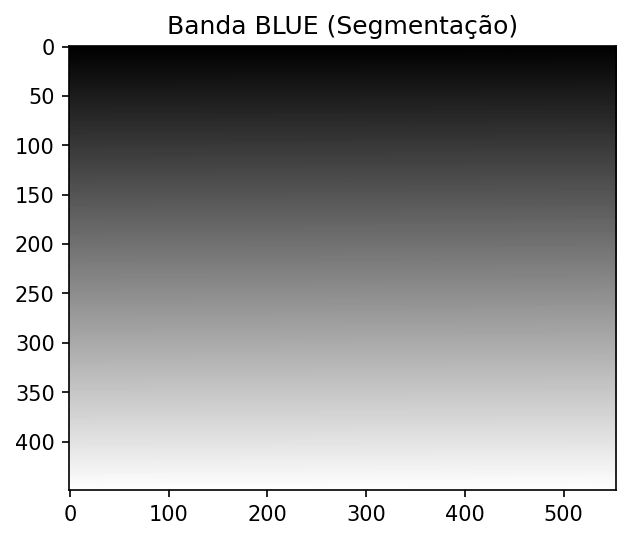

In [339]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title("Banda BLUE (Segmentação)")
plt.imshow(matriz_blue, cmap='gray')

In [340]:
min_blue, max_blue = band_blue.ComputeRasterMinMax()

print(min_blue, max_blue)

0.0 62155.0


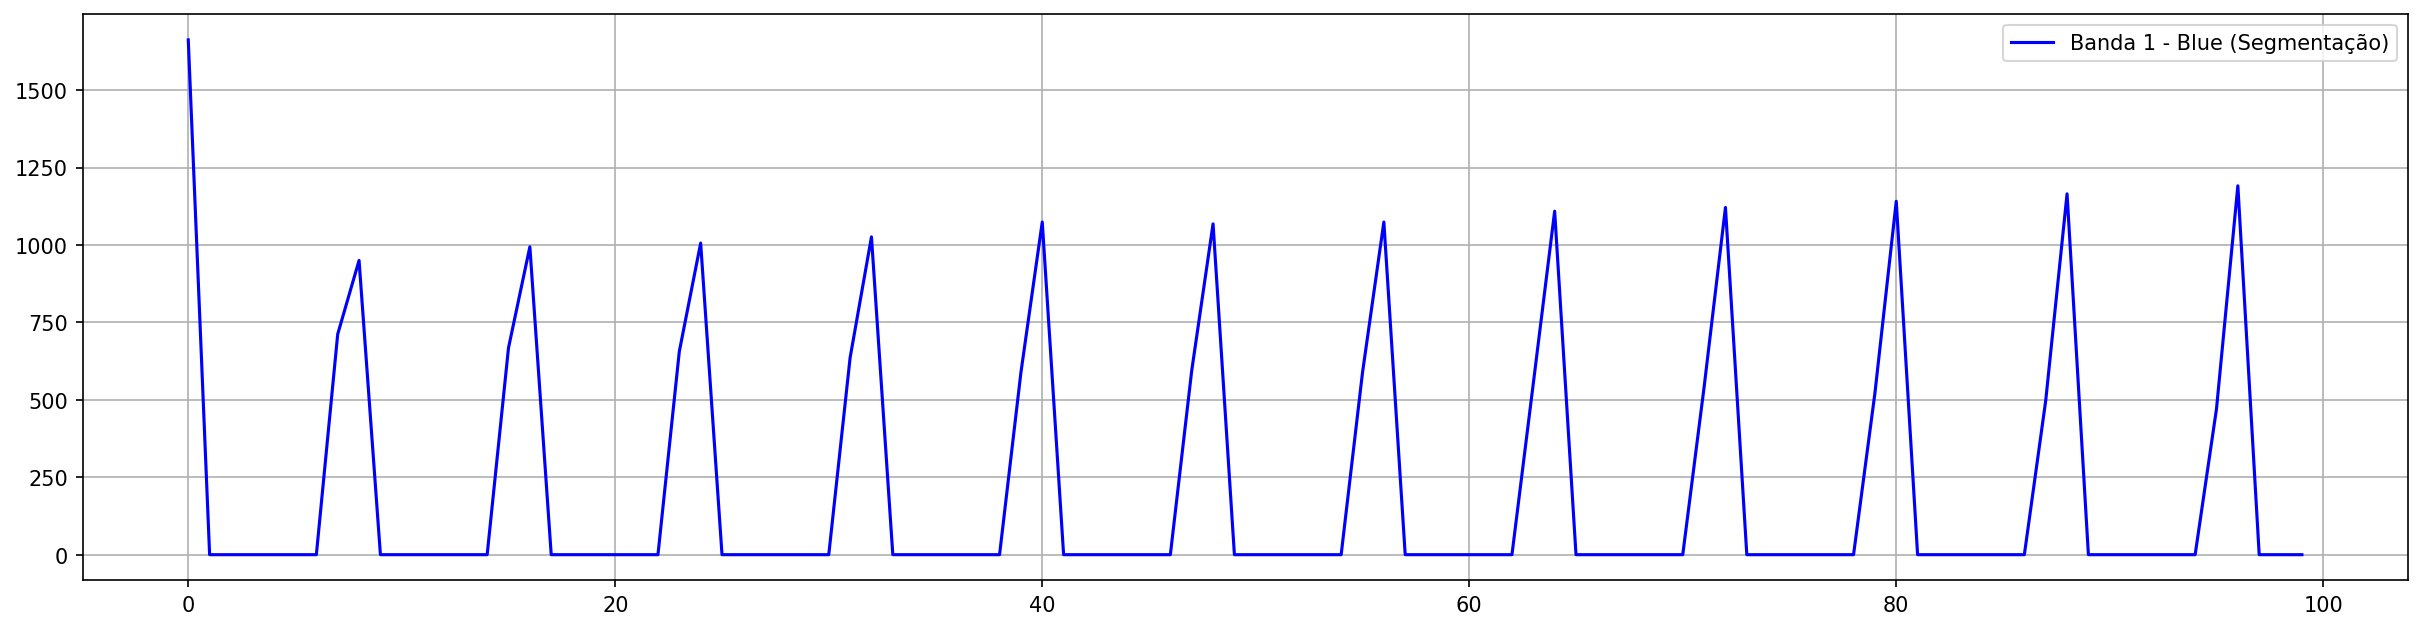

In [341]:
plt.figure(figsize=(20, 5))
plt.plot(band_blue.GetHistogram(min=min_blue, max=max_blue, buckets=100), 'b', label='Banda 1 - Blue (Segmentação)')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Banda 1 - Blue (Segmentação)')

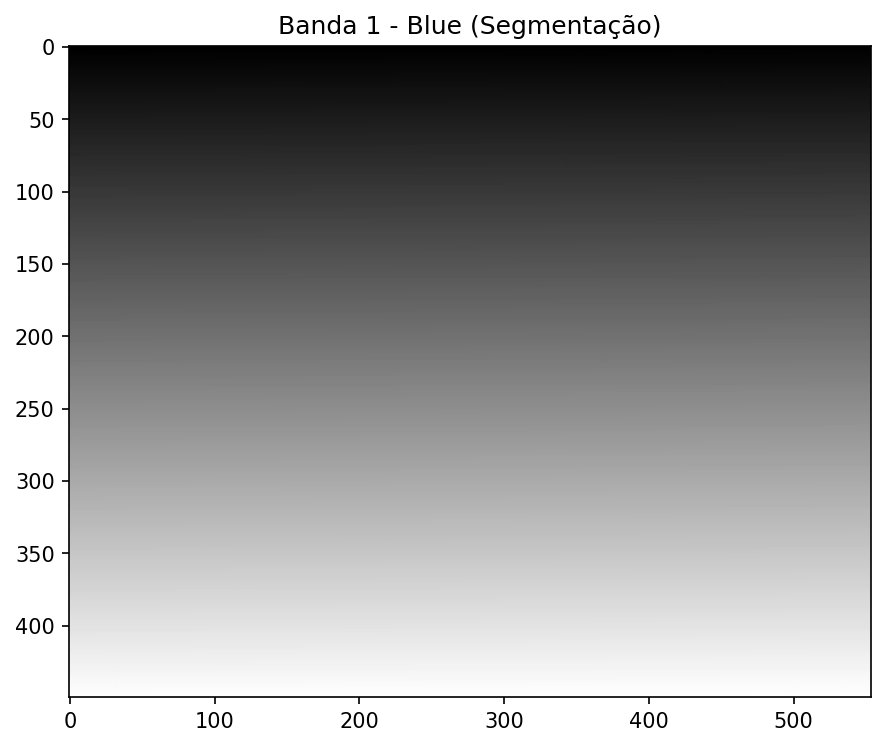

In [342]:
# obter as matrizes de pixels da banda
blue = band_blue.ReadAsArray()

# combinamos GDAL e Matplotlib para
# visualizar as bandas individualmente
plt.figure(figsize=(40, 10))
plt.subplot(151)
plt.imshow(blue, cmap='gray')
plt.title('Banda 1 - Blue (Segmentação)')

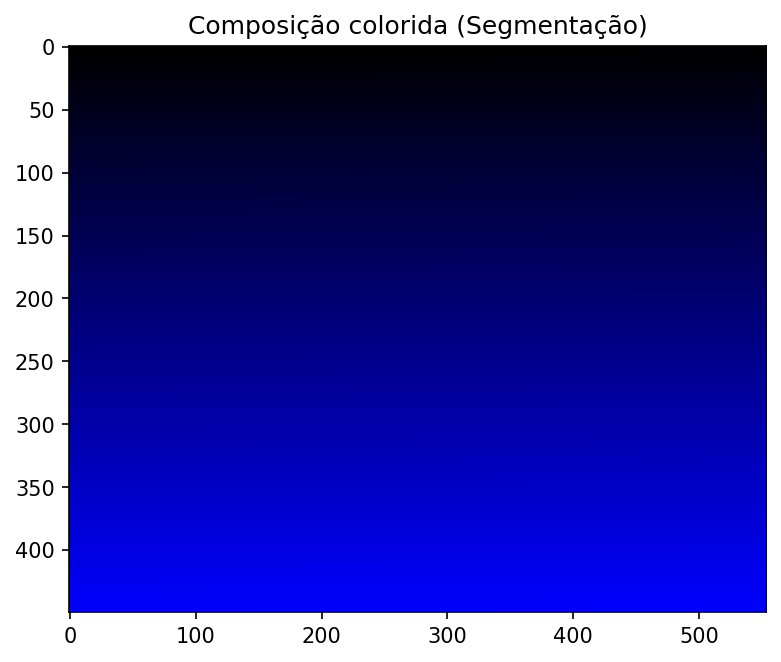

In [343]:
# 4.3.1. Composição colorida e Contraste
# definimos os números de linhas/colunas
# a partir de alguma matriz da imagem original
# Após segmentação - 1 banda
linhas = blue.shape[0]
colunas = blue.shape[1]

# para criar uma visualização em cores
# verdadeiras, podemos associar as bandas
# do CBERS 04A 3 - Red, 2 - Green, 1 - Blue
# para isso criamos uma matriz com 3 dimensões
# (3 x linhas x colunas)
array_rgb = np.zeros((linhas, colunas, 3))

# veja que, para visualizar corretamente,
# precisaremos dividir as matrizes pelo
# maior valor, para obtermos uma matriz
# com valores normalizados entre 0.0 e 1.0
# array_rgb[:, :, 0] = red / red.max()
# array_rgb[:, :, 1] = green / green.max()
array_rgb[:, :, 2] = blue / blue.max()

plt.figure(figsize=(20, 5))
plt.imshow(array_rgb)
plt.title('Composição colorida (Segmentação)');

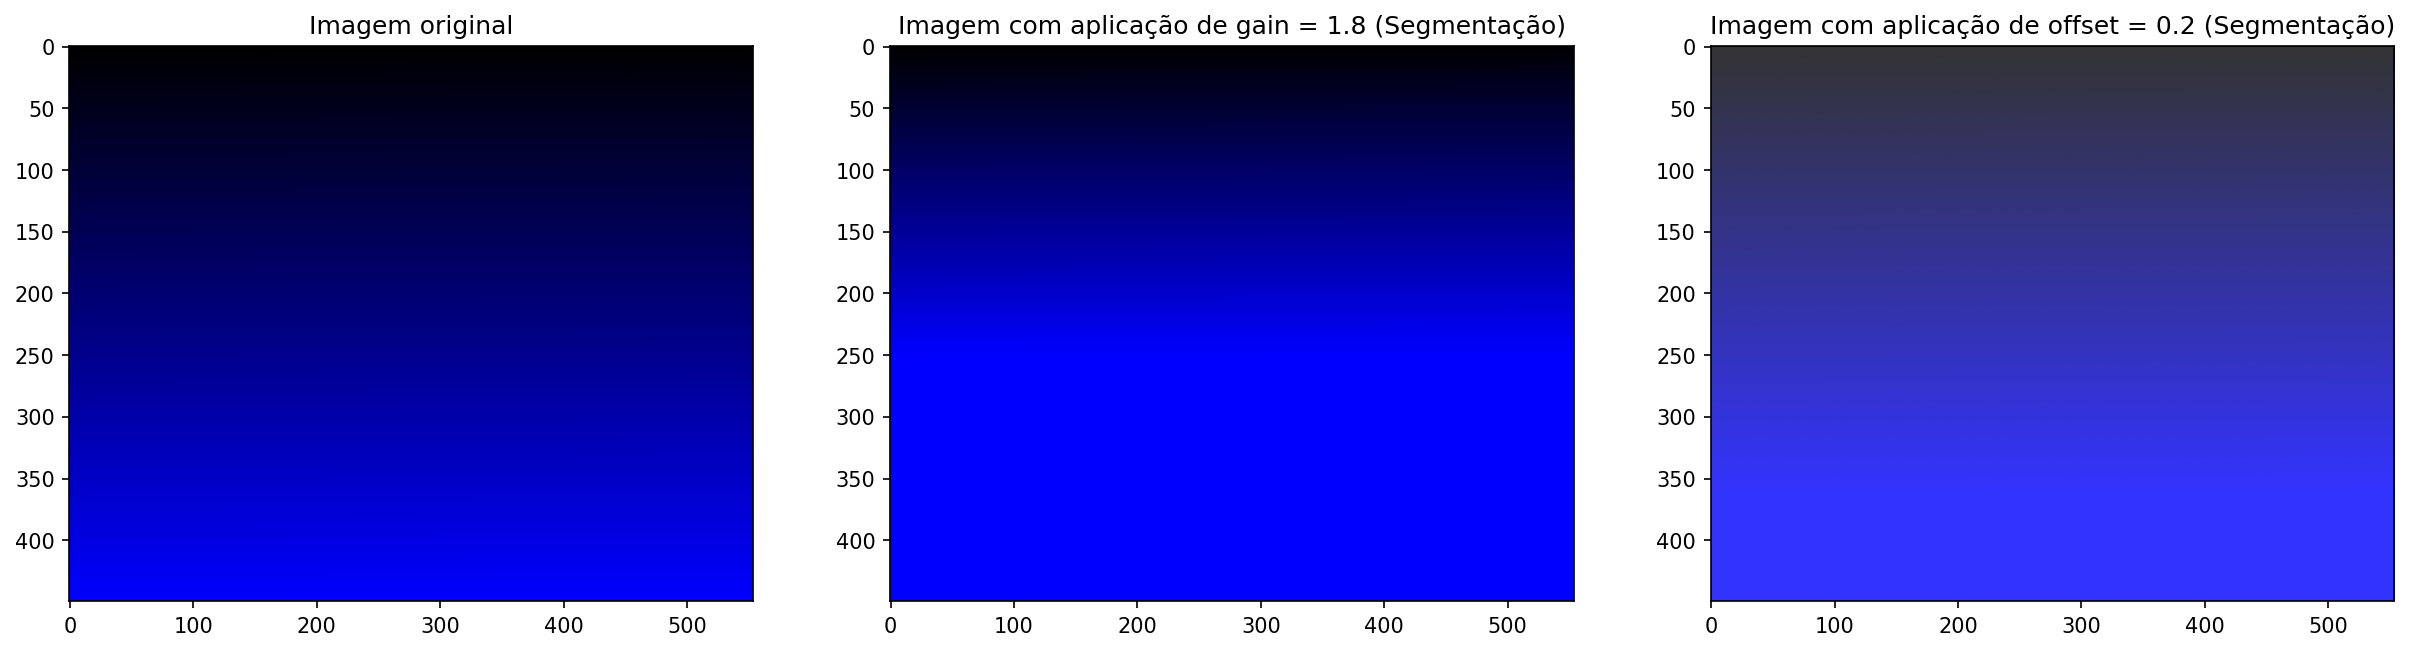

In [344]:
# Para realizar análises baseadas no comportamento espectral das imagens,
# técnicas de contraste devem ser evitadas.

# lembrando que os valores em array_rgb
# foram normalizados entre 0.0 e 1.0
gain = 1.8
offset = 0.2

# como no exemplo anterior criamos um
# array_rgb, vamos alterar uma cópia deste
# array com as operações de gain/offset
# para não comprometer os dados originais

array_rgb_gain = array_rgb.copy()
array_rgb_gain *= gain

array_rgb_offset = array_rgb.copy()
array_rgb_offset += offset

# apresentação dos resultados
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow(array_rgb)
plt.title(f'Imagem original');

plt.subplot(132)
plt.imshow(array_rgb_gain)
plt.title(f'Imagem com aplicação de gain = {gain} (Segmentação)');

plt.subplot(133)
plt.imshow(array_rgb_offset)
plt.title(f'Imagem com aplicação de offset = {offset} (Segmentação)');

# pesquisar para fazer paletted/unique values - classify

# Imagem criada pelo Teste da Regressão MLPRegressor

In [345]:
regressor_fn = '/content/regressor_mlpr.tif' 
driverTiff = gdal.GetDriverByName('GTiff')
regressor_ds = gdal.Open(regressor_fn)
type(regressor_ds)

osgeo.gdal.Dataset

In [346]:
# obter os objetos com as informações das bandas
band_blue  = regressor_ds.GetRasterBand(1)
print("Tipos de dados:")
print(" - banda BLUE:", gdal.GetDataTypeName(band_blue.DataType))

Tipos de dados:
 - banda BLUE: Float32


In [347]:
matriz_blue = band_blue.ReadAsArray()
matriz_blue = matriz_blue.astype(float)

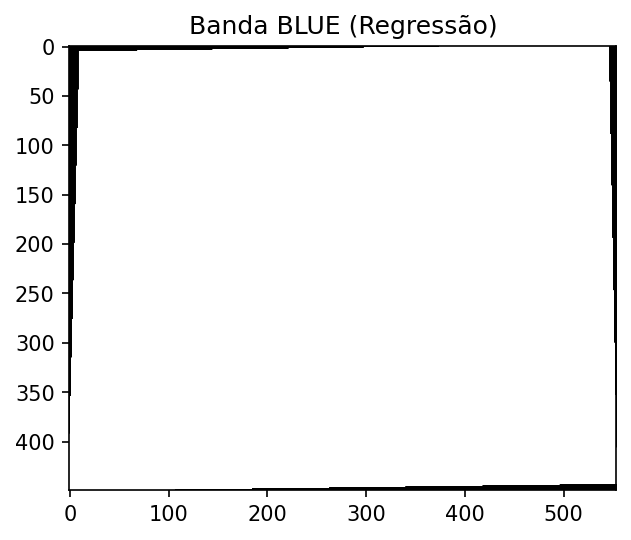

In [348]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title("Banda BLUE (Regressão)")
plt.imshow(matriz_blue, cmap='gray')

In [349]:
min_blue, max_blue = band_blue.ComputeRasterMinMax()
print(min_blue, max_blue)

0.0 3.0


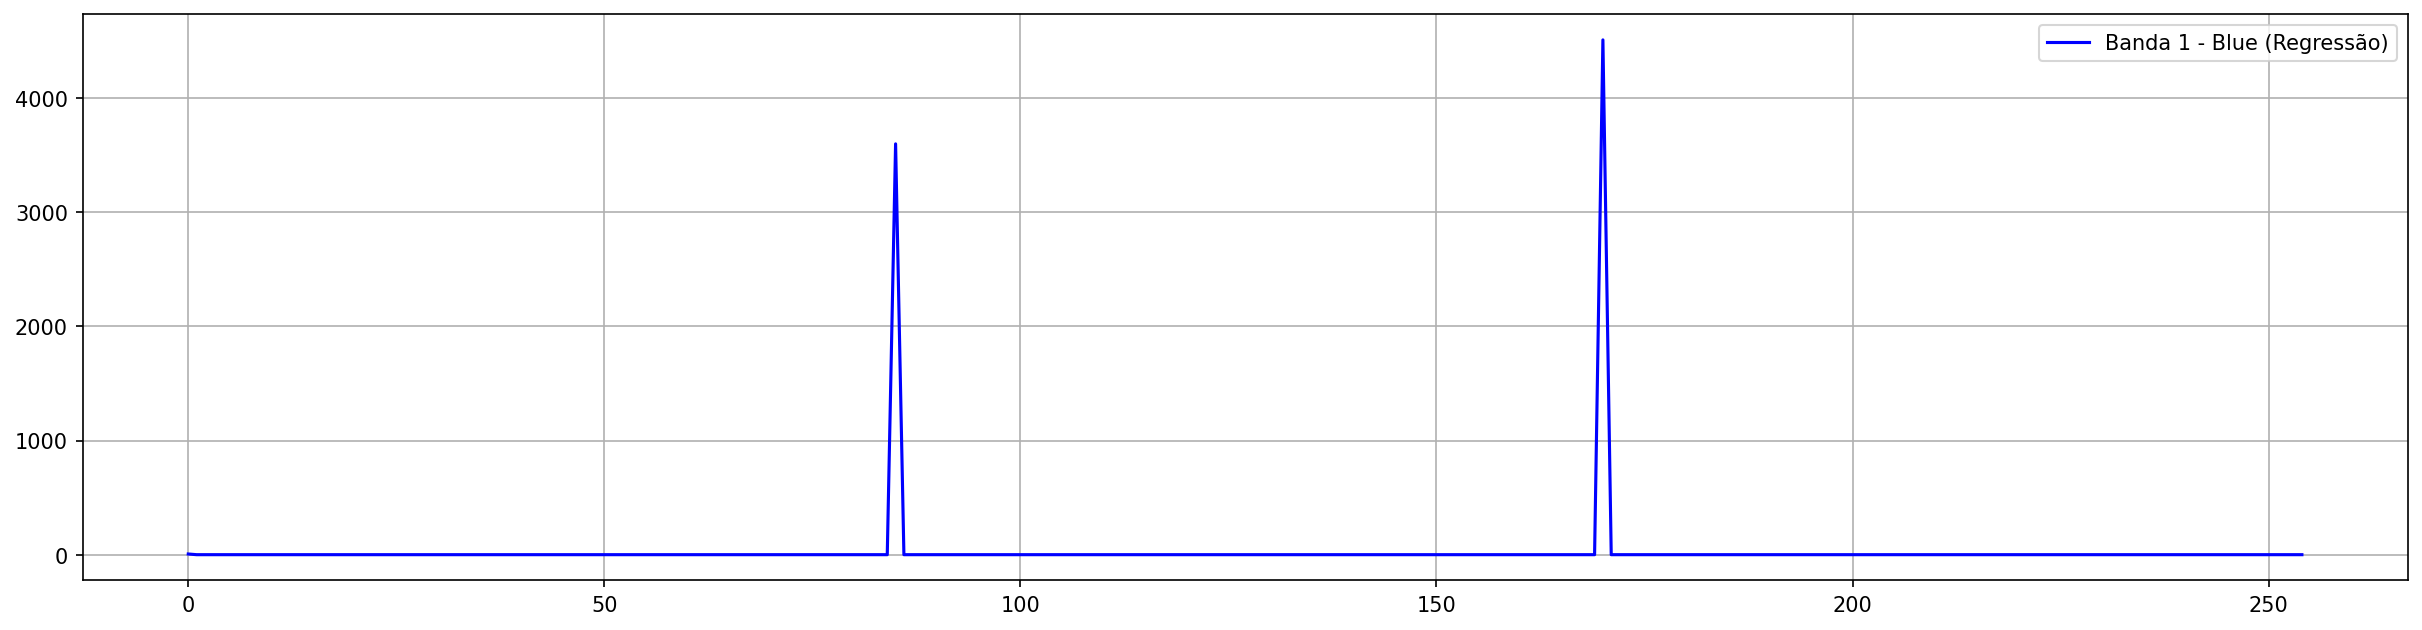

In [350]:
plt.figure(figsize=(20, 5))
plt.plot(band_blue.GetHistogram(min=min_blue, max=max_blue, buckets=255), 'b', label='Banda 1 - Blue (Regressão)')
plt.grid()
plt.legend()
# Este histograma apresenta as informações divididas em 100 partes, ou buckets. 
# Portanto, o eixo x não contém os valores de números digitais originais da imagem,
# e sim os valores espaçados no intervalo definido pelos parâmetros min e max. (buckets=255?)

Text(0.5, 1.0, 'Banda 1 - Blue (Regressão)')

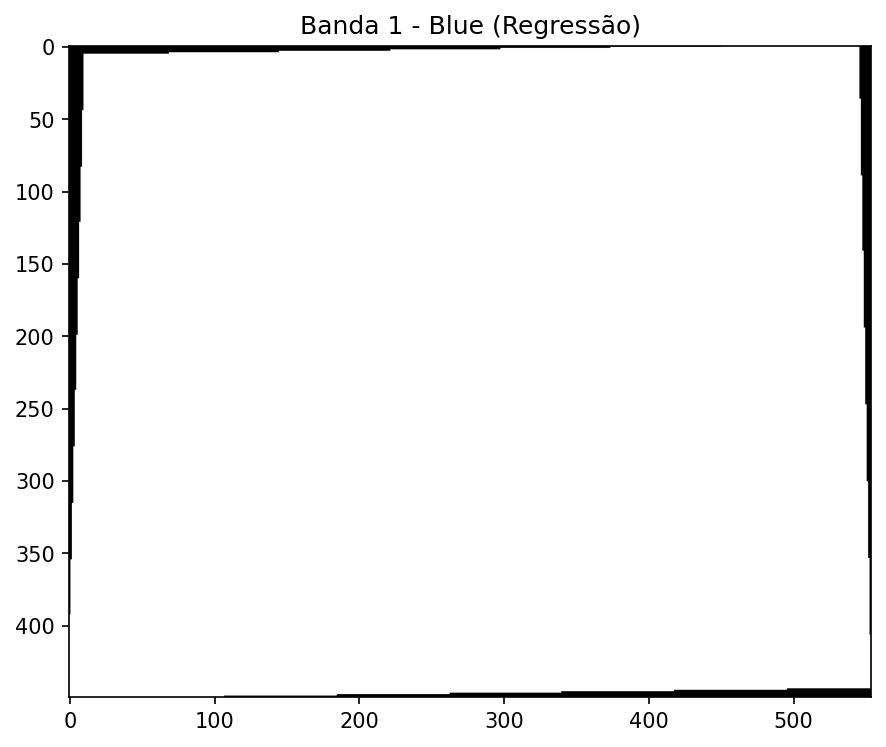

In [351]:
# obter as matrizes de pixels de cada banda
blue = band_blue.ReadAsArray()
# combinamos GDAL e Matplotlib para
# visualizar as bandas individualmente
plt.figure(figsize=(40, 10))
plt.subplot(151)
plt.imshow(blue, cmap='gray')
plt.title('Banda 1 - Blue (Regressão)')

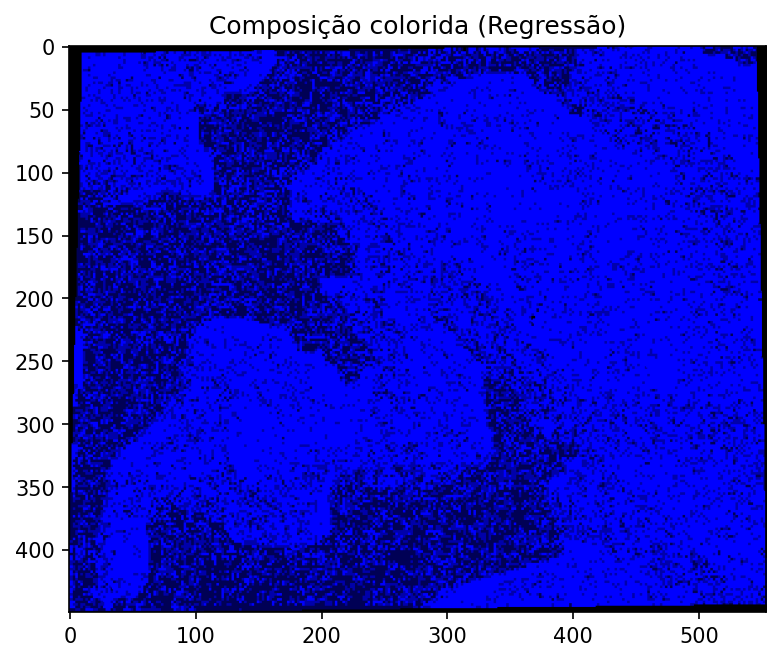

In [352]:
# 4.3.1. Composição colorida e Contraste
# definimos os números de linhas/colunas
# a partir de alguma matriz da imagem original
# Após segmentação - 1 banda
linhas = blue.shape[0]
colunas = blue.shape[1]
# para criar uma visualização em cores
# verdadeiras, podemos associar as bandas
# do CBERS 04A 3 - Red, 2 - Green, 1 - Blue
# para isso criamos uma matriz com 3 dimensões
# (3 x linhas x colunas)
array_rgb = np.zeros((linhas, colunas, 3))
# veja que, para visualizar corretamente,
# precisaremos dividir as matrizes pelo
# maior valor, para obtermos uma matriz
# com valores normalizados entre 0.0 e 1.0
# array_rgb[:, :, 0] = red / red.max()
# array_rgb[:, :, 1] = green / green.max()
array_rgb[:, :, 2] = blue / blue.max()
plt.figure(figsize=(20, 5))
plt.imshow(array_rgb)
plt.title('Composição colorida (Regressão)');

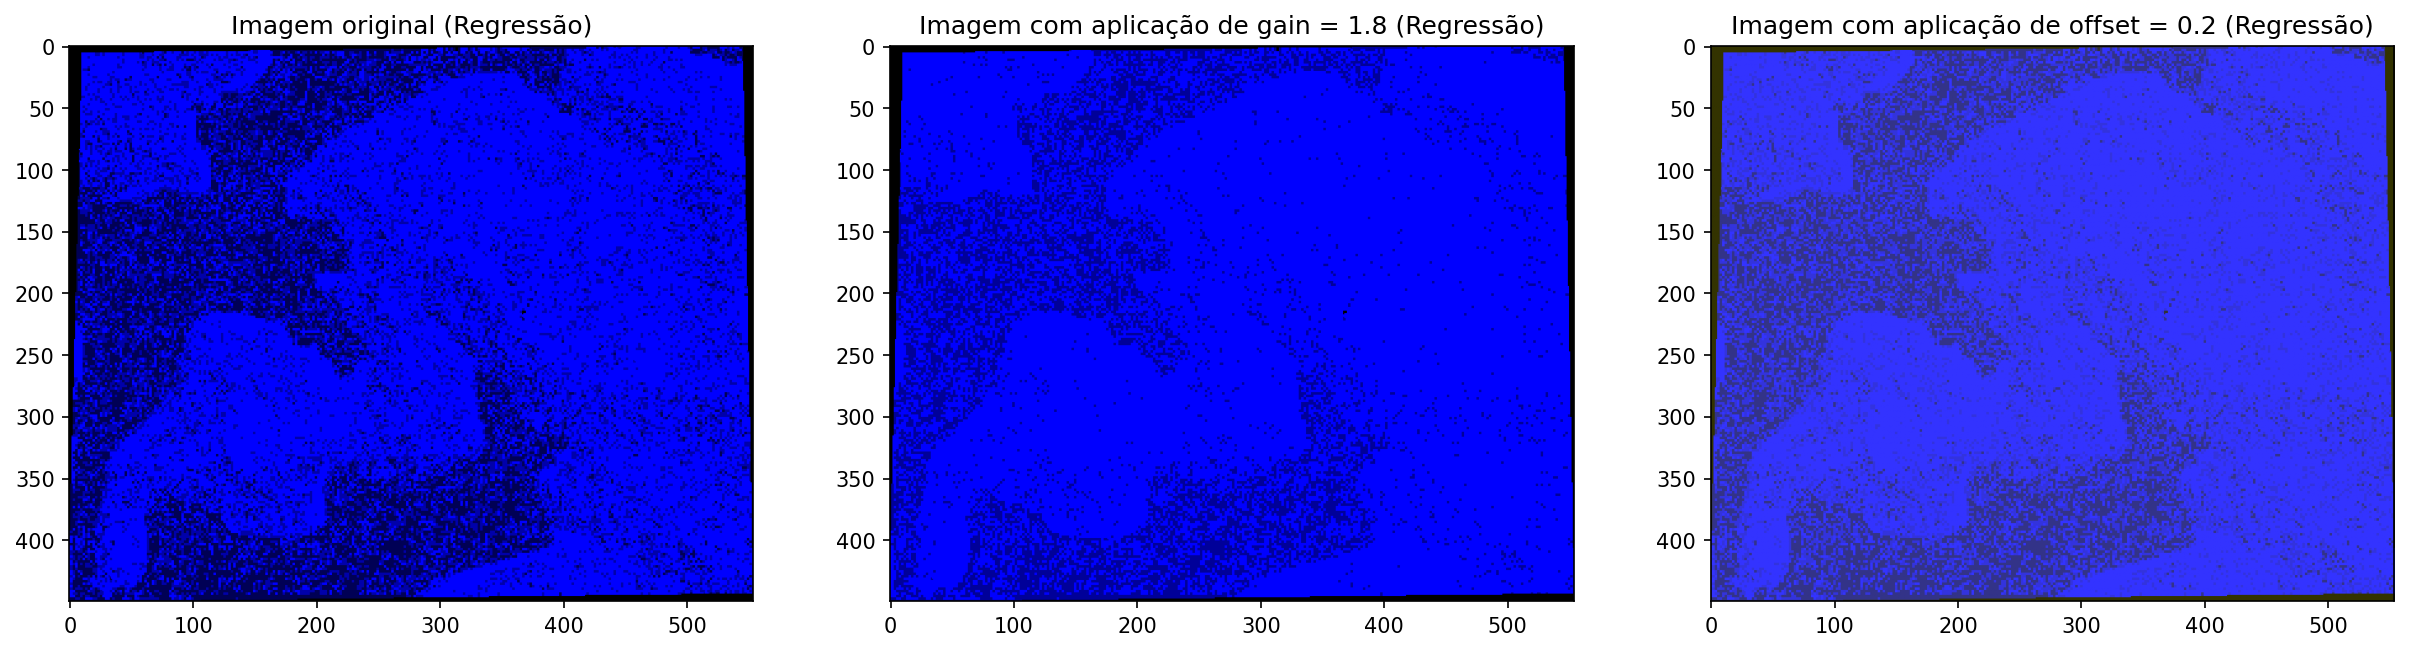

In [353]:
# Para realizar análises baseadas no comportamento espectral das imagens,
# técnicas de contraste devem ser evitadas.
# lembrando que os valores em array_rgb
# foram normalizados entre 0.0 e 1.0
gain = 1.8
offset = 0.2
# como no exemplo anterior criamos um
# array_rgb, vamos alterar uma cópia deste
# array com as operações de gain/offset
# para não comprometer os dados originais
array_rgb_gain = array_rgb.copy()
array_rgb_gain *= gain
array_rgb_offset = array_rgb.copy()
array_rgb_offset += offset
# apresentação dos resultados
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow(array_rgb)
plt.title(f'Imagem original (Regressão)');
plt.subplot(132)
plt.imshow(array_rgb_gain)
plt.title(f'Imagem com aplicação de gain = {gain} (Regressão)');
plt.subplot(133)
plt.imshow(array_rgb_offset)
plt.title(f'Imagem com aplicação de offset = {offset} (Regressão)');

# Imagem Original

In [354]:
################### INFOS BANDS ORIGINAL ################################
# obter os objetos com as informações das bandas
band_blue  = naip_ds.GetRasterBand(1)
band_green = naip_ds.GetRasterBand(2)
band_red = naip_ds.GetRasterBand(3)
band_nir = naip_ds.GetRasterBand(4)
print("Tipos de dados:")
print(" - banda BLUE:", gdal.GetDataTypeName(band_blue.DataType))
print(" - banda GREEN:", gdal.GetDataTypeName(band_green.DataType))
print(" - banda RED:", gdal.GetDataTypeName(band_red.DataType))
print(" - banda NIR:", gdal.GetDataTypeName(band_nir.DataType))

Tipos de dados:
 - banda BLUE: Float32
 - banda GREEN: Float32
 - banda RED: Float32
 - banda NIR: Float32


In [355]:
matriz_red = band_red.ReadAsArray()
matriz_nir = band_nir.ReadAsArray()

In [356]:
matriz_red = matriz_red.astype(float)
matriz_nir = matriz_nir.astype(float)
# geracao de array derivado das bandas
matriz_ndvi = (matriz_nir - matriz_red) / \
              (matriz_nir + matriz_red + 0.000000001)
# mostrar as dimensoes e tipo de dado da matriz de saida
print(matriz_ndvi.shape)
print(matriz_ndvi.dtype)

(450, 554)
float64


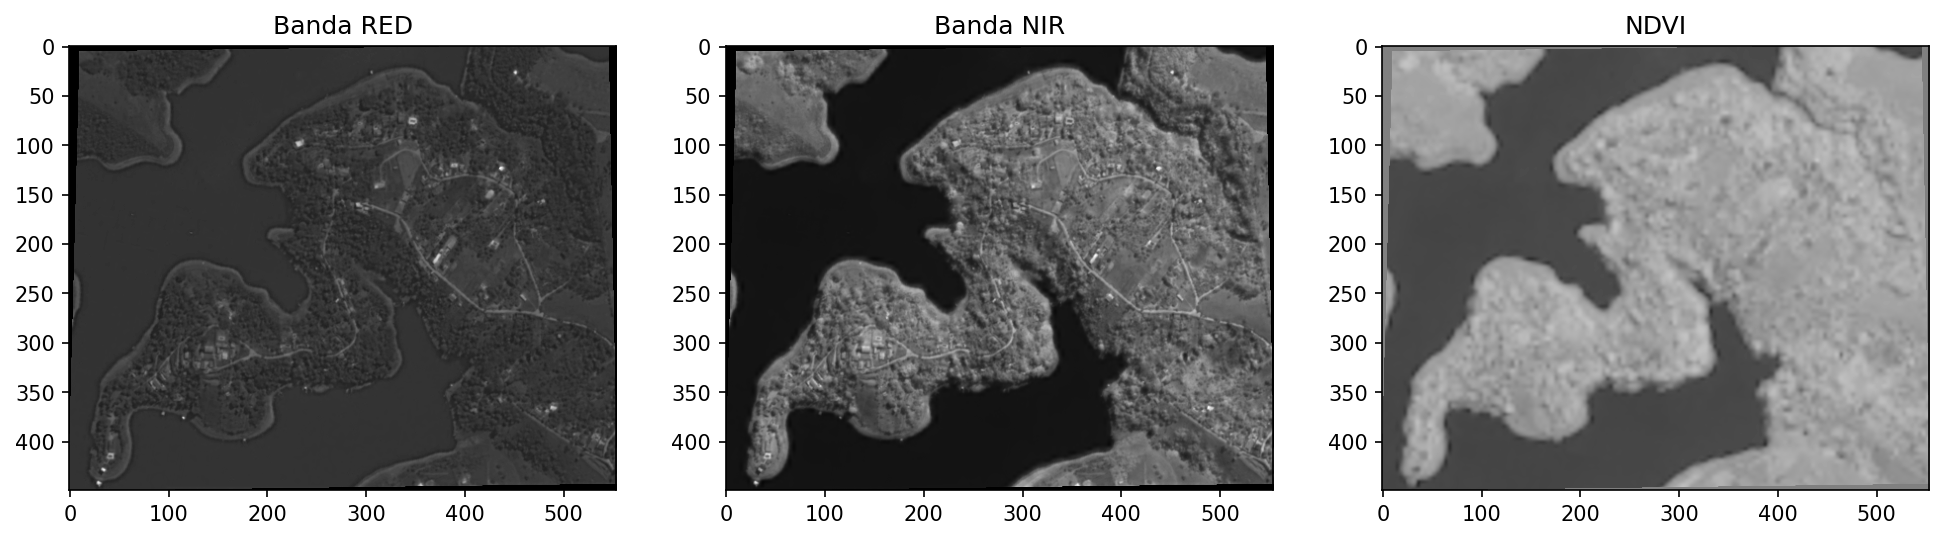

In [357]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title("Banda RED")
plt.imshow(matriz_red, cmap='gray')
plt.subplot(132)
plt.title("Banda NIR")
plt.imshow(matriz_nir, cmap='gray')
plt.subplot(133)
plt.title("NDVI")
plt.imshow(matriz_ndvi, cmap='gray', vmin=-1.0, vmax=1.0)

In [358]:
min_blue, max_blue = band_blue.ComputeRasterMinMax()
min_green, max_green = band_green.ComputeRasterMinMax()
min_red, max_red = band_red.ComputeRasterMinMax()
min_nir, max_nir = band_nir.ComputeRasterMinMax()
print(min_nir, max_nir)

45.4295768737793 1570.8221435546875


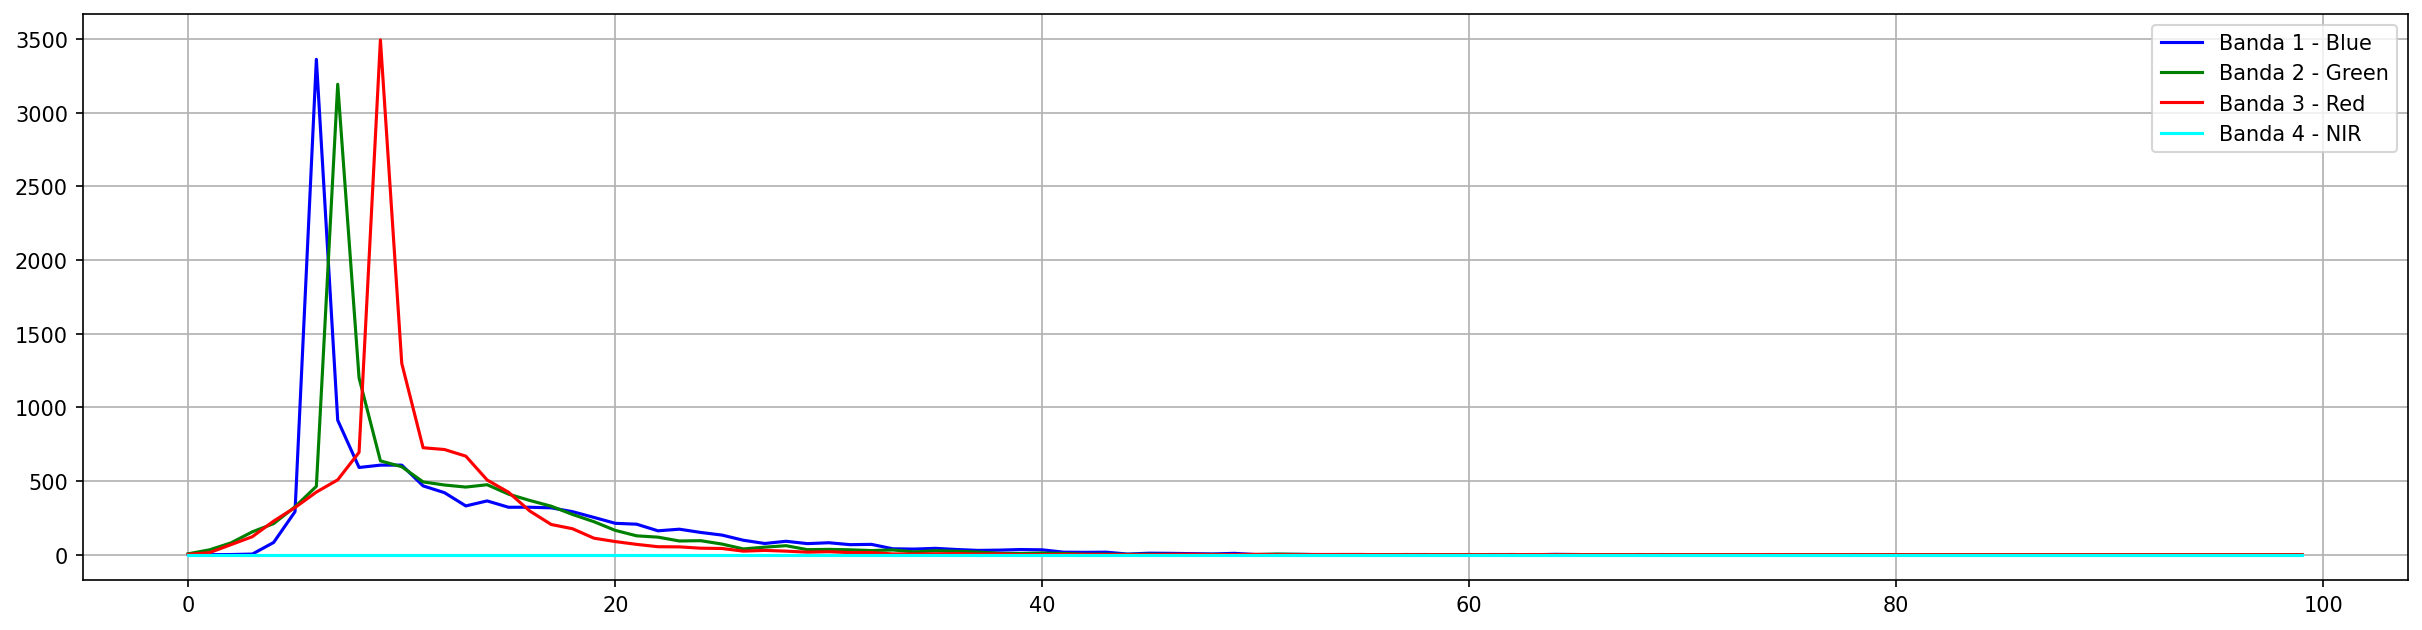

In [359]:
# a função GetHistogram precisa de intervalos
# mínimos e máximos de pixels para cada banda (min/max)
# e também a informação de divisões do gráfico (buckets)
plt.figure(figsize=(20, 5))
plt.plot(band_blue.GetHistogram(min=min_blue, max=max_blue, buckets=100), 'b', label='Banda 1 - Blue')
plt.plot(band_green.GetHistogram(min=min_green, max=max_green, buckets=100), 'g', label='Banda 2 - Green')
plt.plot(band_red.GetHistogram(min=min_red, max=max_red, buckets=100), 'r', label='Banda 3 - Red')
plt.plot(band_nir.GetHistogram(min=min_nir, max=MAXDIMS, buckets=100), 'cyan', label='Banda 4 - NIR')
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Banda 4 - NIR')

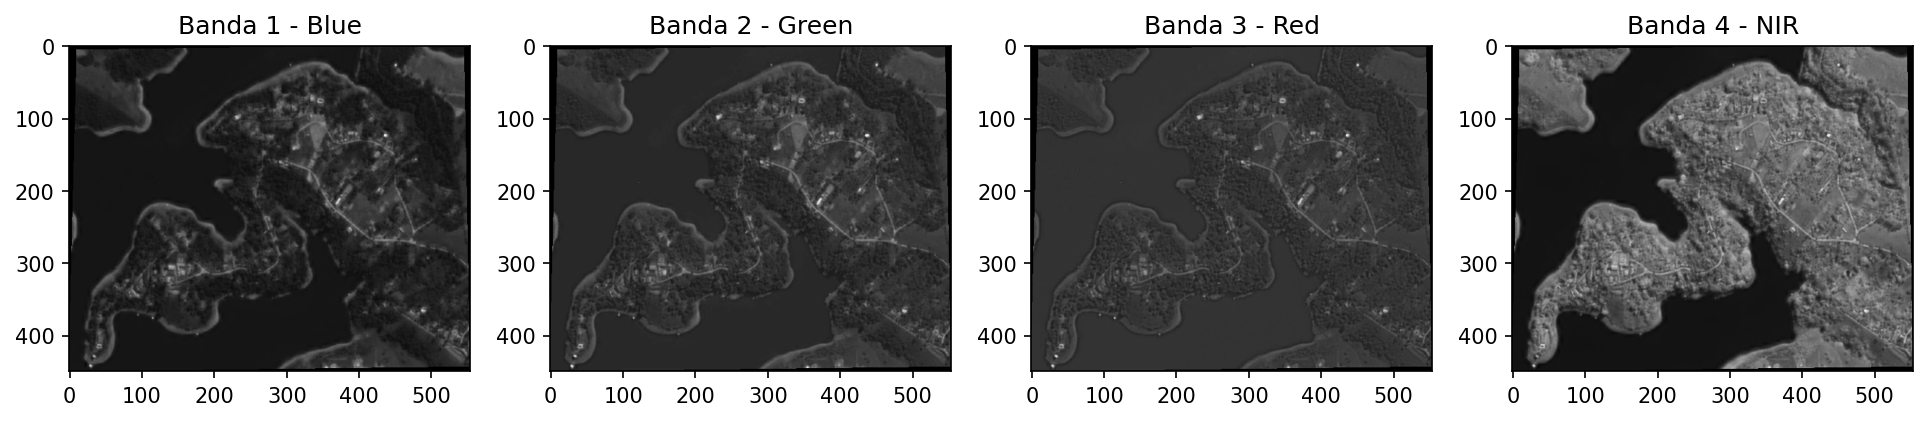

In [360]:
# obter as matrizes de pixels de cada banda
blue = band_blue.ReadAsArray()
green = band_green.ReadAsArray()
red = band_red.ReadAsArray()
nir = band_nir.ReadAsArray()
# combinamos GDAL e Matplotlib para
# visualizar as bandas individualmente
plt.figure(figsize=(20, 5))
plt.subplot(151)
plt.imshow(blue, cmap='gray')
plt.title('Banda 1 - Blue')
plt.subplot(152)
plt.imshow(green, cmap='gray')
plt.title('Banda 2 - Green')
plt.subplot(153)
plt.imshow(red, cmap='gray')
plt.title('Banda 3 - Red')
plt.subplot(154)
plt.imshow(nir, cmap='gray')
plt.title('Banda 4 - NIR')

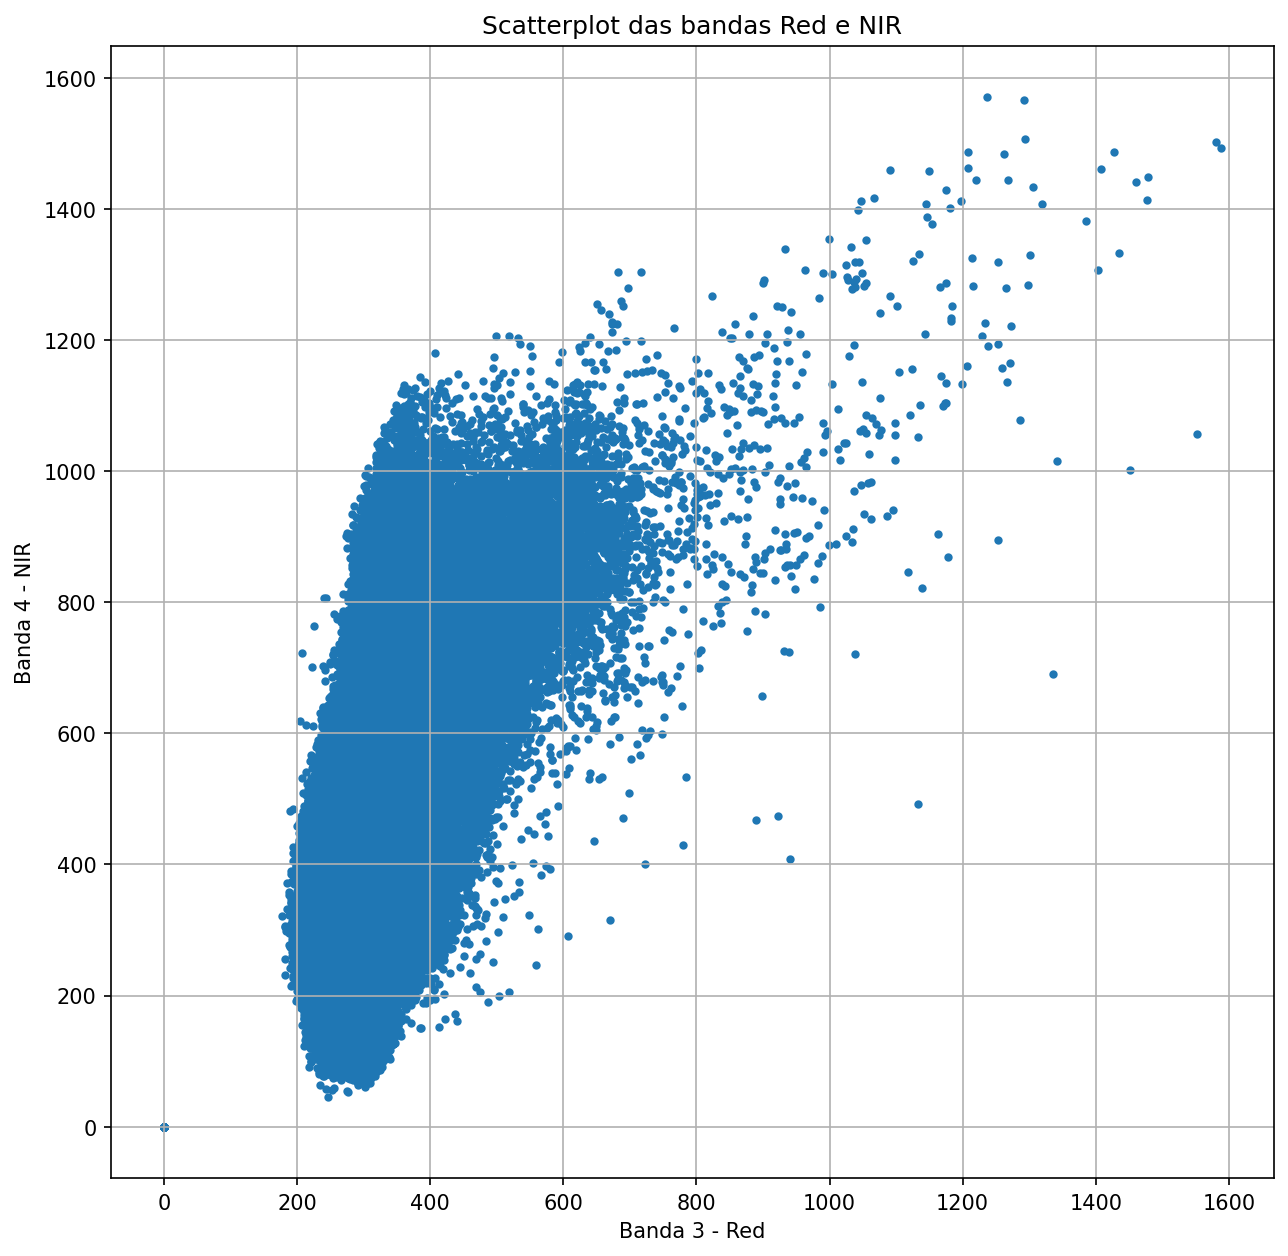

In [361]:
# obter os vetores de 1 dimensão de cada banda
vetor_red = red.flatten()
vetor_nir = nir.flatten()
# construir o gráfico com o scatterplot
plt.figure(figsize=(10, 10))
plt.scatter(vetor_red, vetor_nir, marker='.')
plt.xlabel("Banda 3 - Red")
plt.ylabel("Banda 4 - NIR")
plt.title("Scatterplot das bandas Red e NIR")
plt.grid();